# Collaboration and Competition

---

In this notebook, MADPPG agent will be implemented and tested on the Tennis Unity Environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="C:\\Users\\anindex\\Desktop\\Tennis_Windows_x86_64\\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Training MADDPG agent

The implementation for MADDPG agent is imported from this repository subfolder `agents/` as a library. 

In [5]:
import sys
import os
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#uncomment the following line if import failed
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))

from agents.agents import MADDPGAgent

agent = MADDPGAgent(state_size, action_size, random_seed=0, num_agents=num_agents)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                   [-1, 24]              48
            Linear-2                  [-1, 256]           6,400
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 128]          32,896
       BatchNorm1d-5                  [-1, 128]             256
            Linear-6                    [-1, 2]             258
Total params: 40,370
Trainable params: 40,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------
MAFCPolicy(
  (bn_input): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (bn

In [6]:
def train_maddpg(n_episodes=2000, max_t=1000, start_episode=1, print_every=100, save_every=500, saving=False, eps=1.0, eps_linear_decay=5e-6, eps_min=0.1):
    """MADDPG 
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    saved = False

    for i_episode in range(start_episode, start_episode+n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        
        states = env_info.vector_observations
        current_scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states, eps)
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations  
            rewards = env_info.rewards                
            dones = env_info.local_done
            current_scores += env_info.rewards
            
            agent.step(states, actions, rewards, next_states, dones)
                
            states = next_states
            eps = max(eps_min, eps - eps_linear_decay)
            if np.any(dones):
                break 
            
        max_current_score = np.max(current_scores)
        scores_window.append(max_current_score)       # save most recent score
        scores.append(max_current_score)              # save most recent score

        mean_score = np.mean(scores_window)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, mean_score, max_current_score))
        if mean_score >= 0.6 and saving and not saved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}, saving models!'.format(i_episode, mean_score))
            for i in range(num_agents):
                torch.save(agent.actor_locals[i].state_dict(), 'actor{}.pth'.format(i))
                torch.save(agent.critic_locals[i].state_dict(), 'critic{}.pth'.format(i))
            saved = True
    return scores

scores = train_maddpg(saving=True)

Episode 100	Average Score: 0.00	Score: 0.00
Episode 200	Average Score: 0.02	Score: 0.00
Episode 300	Average Score: 0.00	Score: 0.00
Episode 400	Average Score: 0.01	Score: 0.00
Episode 500	Average Score: 0.01	Score: 0.00
Episode 600	Average Score: 0.02	Score: 0.00
Episode 700	Average Score: 0.02	Score: 0.00
Episode 800	Average Score: 0.01	Score: 0.00
Episode 900	Average Score: 0.01	Score: 0.09
Episode 1000	Average Score: 0.01	Score: 0.10
Episode 1100	Average Score: 0.00	Score: 0.00
Episode 1200	Average Score: 0.02	Score: 0.10
Episode 1300	Average Score: 0.04	Score: 0.00
Episode 1400	Average Score: 0.06	Score: 0.10
Episode 1500	Average Score: 0.10	Score: 0.10
Episode 1600	Average Score: 0.12	Score: 0.00
Episode 1700	Average Score: 0.14	Score: 0.10
Episode 1800	Average Score: 0.17	Score: 0.10

Environment solved in 1862 episodes!	Average Score: 0.62, saving models!

Environment solved in 1863 episodes!	Average Score: 0.63, saving models!

Environment solved in 1864 episodes!	Average Score


Environment solved in 1962 episodes!	Average Score: 1.44, saving models!

Environment solved in 1963 episodes!	Average Score: 1.42, saving models!

Environment solved in 1964 episodes!	Average Score: 1.44, saving models!

Environment solved in 1965 episodes!	Average Score: 1.46, saving models!

Environment solved in 1966 episodes!	Average Score: 1.44, saving models!

Environment solved in 1967 episodes!	Average Score: 1.44, saving models!

Environment solved in 1968 episodes!	Average Score: 1.42, saving models!

Environment solved in 1969 episodes!	Average Score: 1.42, saving models!

Environment solved in 1970 episodes!	Average Score: 1.40, saving models!

Environment solved in 1971 episodes!	Average Score: 1.40, saving models!

Environment solved in 1972 episodes!	Average Score: 1.40, saving models!

Environment solved in 1973 episodes!	Average Score: 1.42, saving models!

Environment solved in 1974 episodes!	Average Score: 1.45, saving models!

Environment solved in 1975 episodes!	

This cell log is a bit overwhelming, since it is run before I implement the one-time saving. However, as can be seen, the mean window score reached the value 1.35 after 2000 episodes. 

In [7]:
# run this cell for saving current scores and actor&critic state_dict

import pickle

with open('MADDPG_train_score', 'wb') as fp:
    pickle.dump(scores, fp)
    
for i in range(num_agents):
    torch.save(agent.actor_locals[i].state_dict(), 'actor{}.pth'.format(i))
    torch.save(agent.critic_locals[i].state_dict(), 'critic{}.pth'.format(i))

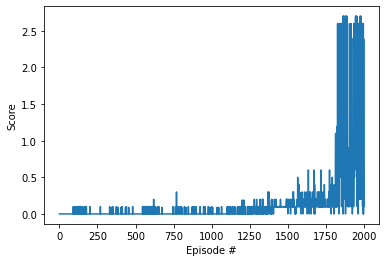

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Evaluate the agent

We will then observe the trained behavior of the MADDPG agent and finally record the max score between 2 agents. The next cell will load the saved model and then we can test the model on the env.

In [6]:
agent = MADDPGAgent(state_size, action_size, random_seed=0, num_agents=num_agents)

if os.path.isfile('actor0.pth') and os.path.isfile('actor1.pth'):
    agent.actor_locals[0].load_state_dict(torch.load('actor0.pth'))
    agent.actor_locals[1].load_state_dict(torch.load('actor1.pth'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                   [-1, 24]              48
            Linear-2                  [-1, 256]           6,400
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 128]          32,896
       BatchNorm1d-5                  [-1, 128]             256
            Linear-6                    [-1, 2]             258
Total params: 40,370
Trainable params: 40,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------
MAFCPolicy(
  (bn_input): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (bn

In [7]:
def test_maddpg(n_episodes=2000, max_t=1000, start_episode=1, print_every=100):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    for i_episode in range(start_episode, start_episode+n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        
        states = env_info.vector_observations
        current_scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)                        # select an action (for each agent)

            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            current_scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        max_score = np.max(current_scores)
        scores_window.append(max_score)       # save most recent score
        scores.append(max_score)              # save most recent score
        mean_score = np.mean(scores_window)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, mean_score, max_score))
    return scores

scores = test_maddpg(n_episodes=200)

Episode 100	Average Score: 1.06	Score: 1.30
Episode 200	Average Score: 0.96	Score: 2.60


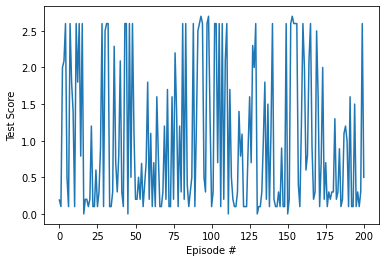

In [8]:
# plot the test scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Test Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    
    while True:
        actions = agent.act(states)
        
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 1.9900000300258398
Score (max over agents) from episode 3: 0.20000000298023224
Score (max over agents) from episode 4: 1.1000000163912773
Score (max over agents) from episode 5: 0.10000000149011612


In [10]:
env.close()